# Comparison of logs from torchtune and PEFT

## imports

In [1]:
import re

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

## load data

### load torchtune logs

In [3]:
with open("log_torchtune.txt", "r") as f:
    logs_tt = f.readlines()

In [4]:
pattern = re.compile(r"Step (\d+) \| loss:(\d+\.\d+) lr:(\d+\.\d+(?:e-\d+)?) tokens_per_second_per_gpu:(\d+\.\d+)")
rows = []
for log in logs_tt:
    row = pattern.match(log.strip()).groups()
    step, loss, lr, tps = row
    rows.append((int(step), float(loss), float(lr), float(tps)))

In [5]:
df_tt = pd.DataFrame(rows, columns=["step", "loss", "lr", "tokens_per_second"])

In [6]:
df_tt.shape

(3286, 4)

### load peft logs

In [7]:
with open("log_peft.txt", "r") as f:
    logs_peft = f.readlines()

In [8]:
pattern = re.compile(
    r"Step (\d+) \| loss:(\d+\.\d+) lr:(\d+\.\d+(?:e-\d+)?) tokens_per_second_per_gpu:(\d+\.\d+) "
    r"peak_memory_active:(\d+\.\d+) peak_memory_alloc:(\d+\.\d+) peak_memory_reserved:(\d+\.\d+)")
rows = []
for log in logs_peft:
    row = pattern.match(log.strip()).groups()
    step, loss, lr, dur, peak_memory_active, peak_memory_alloc, peak_memory_reserved = row
    rows.append((int(step), float(loss), float(lr), float(dur), float(peak_memory_active), float(peak_memory_alloc), float(peak_memory_reserved)))

In [9]:
df_peft = pd.DataFrame(
    rows,
    columns=["step", "loss", "lr", "tokens_per_second", "peak_memory_active", "peak_memory_alloc", "peak_memory_reserved"]
)

In [10]:
df_peft.shape

(3255, 7)

### join

In [13]:
df = df_tt.merge(df_peft, on="step", suffixes=("_tt", "_peft"), how="outer")

In [14]:
df.head()

,step,loss_tt,lr_tt,tokens_per_second_tt,loss_peft,lr_peft,tokens_per_second_peft,peak_memory_active,peak_memory_alloc,peak_memory_reserved
0,1,2.282693,0.000003,1168.905228,2.284744,0.000003,1198.762650,19.393236,19.393236,20.302529
1,2,2.092806,0.000006,1375.285783,2.092475,0.000006,1679.598883,20.619119,20.619119,22.179480
2,3,1.860459,0.000009,1829.302974,1.861000,0.000009,2234.102938,23.417011,23.417011,24.186454
3,4,1.952743,0.000012,1635.251281,1.950358,0.000012,1961.021161,21.354696,21.354696,24.192745
4,5,2.073540,0.000015,1531.782233,2.069646,0.000015,1818.022422,21.582753,21.582753,24.192745


## comparison

### loss

<Axes: title={'center': 'loss after 100 steps'}>

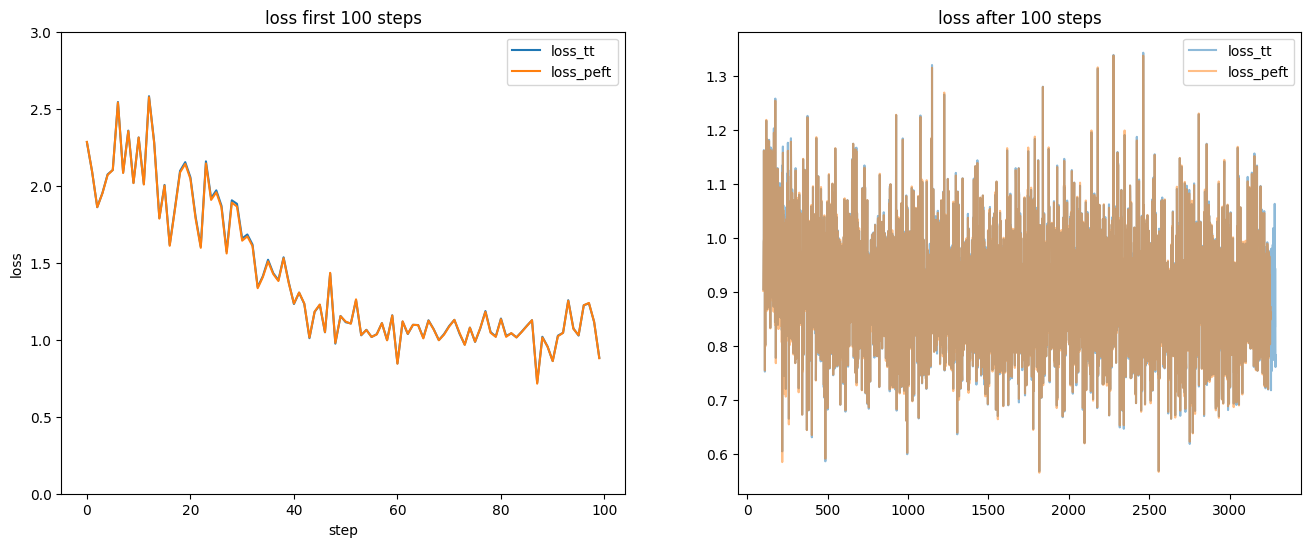

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
kw = {"ylim": [0, 3], "ylabel": "loss", "xlabel": "step"}
df[["loss_tt", "loss_peft"]].head(100).plot(ax=axes[0], title="loss first 100 steps", **kw)
df[["loss_tt", "loss_peft"]].iloc[100:].plot(alpha=0.5, ax=axes[1], title="loss after 100 steps")

### loss (rolling mean)

<Axes: title={'center': 'loss after 100 steps, rolling mean (50)'}, xlabel='step', ylabel='loss'>

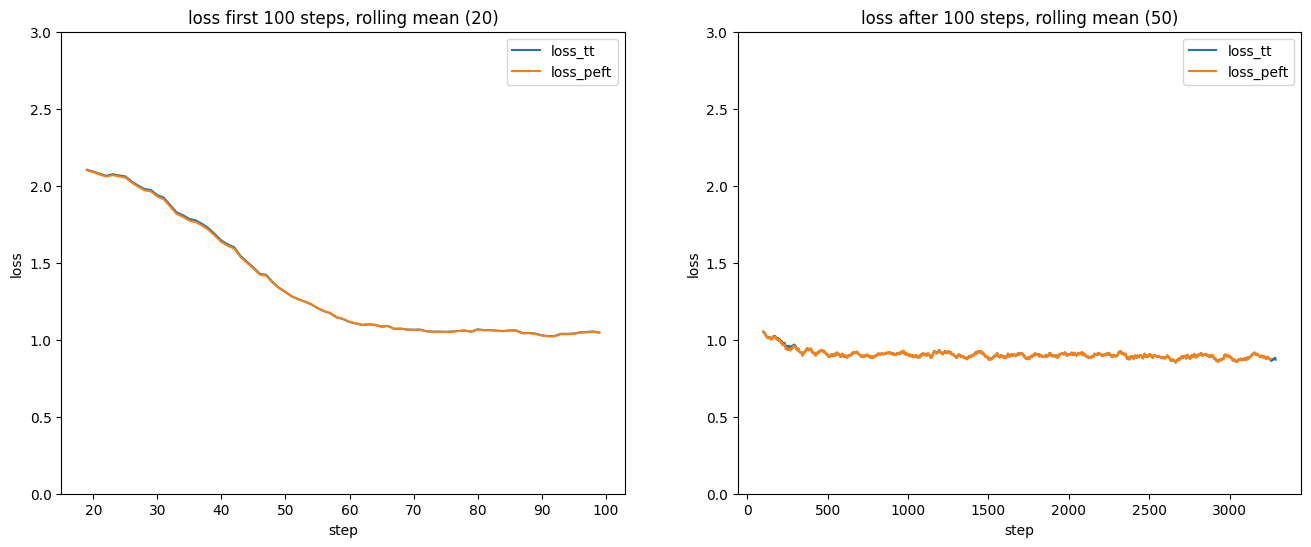

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
kw = {"ylim": [0, 3], "ylabel": "loss", "xlabel": "step"}
df[["loss_tt", "loss_peft"]].rolling(20).mean().head(100).plot(ax=axes[0], title="loss first 100 steps, rolling mean (20)", **kw)
df[["loss_tt", "loss_peft"]].rolling(50).mean().iloc[100:].plot(ax=axes[1], title="loss after 100 steps, rolling mean (50)", **kw)

### tokens per second

<Axes: title={'center': 'tokens per second'}, xlabel='step', ylabel='loss'>

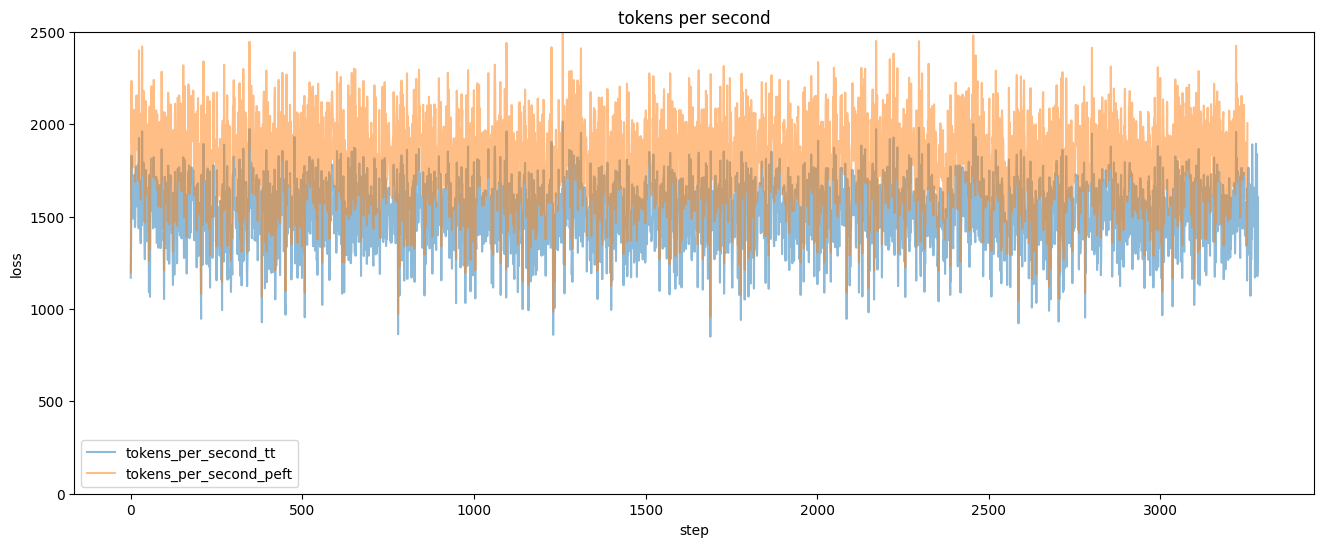

In [17]:
fig, ax = plt.subplots(figsize=(16, 6))
kw = {"ylabel": "loss", "xlabel": "step", "ylim": [0, 2500]}
df[["tokens_per_second_tt", "tokens_per_second_peft"]].plot(ax=ax, alpha=0.5, title="tokens per second", **kw)

Not sure where the difference comes from. I thought it might be because checkpointing was enabled when training the torchtune model, but even when disabling it, the times are pretty much the same.

### tokens per second (rolling mean)

<Axes: title={'center': 'tokens per second, rolling mean (50)'}, xlabel='step', ylabel='loss'>

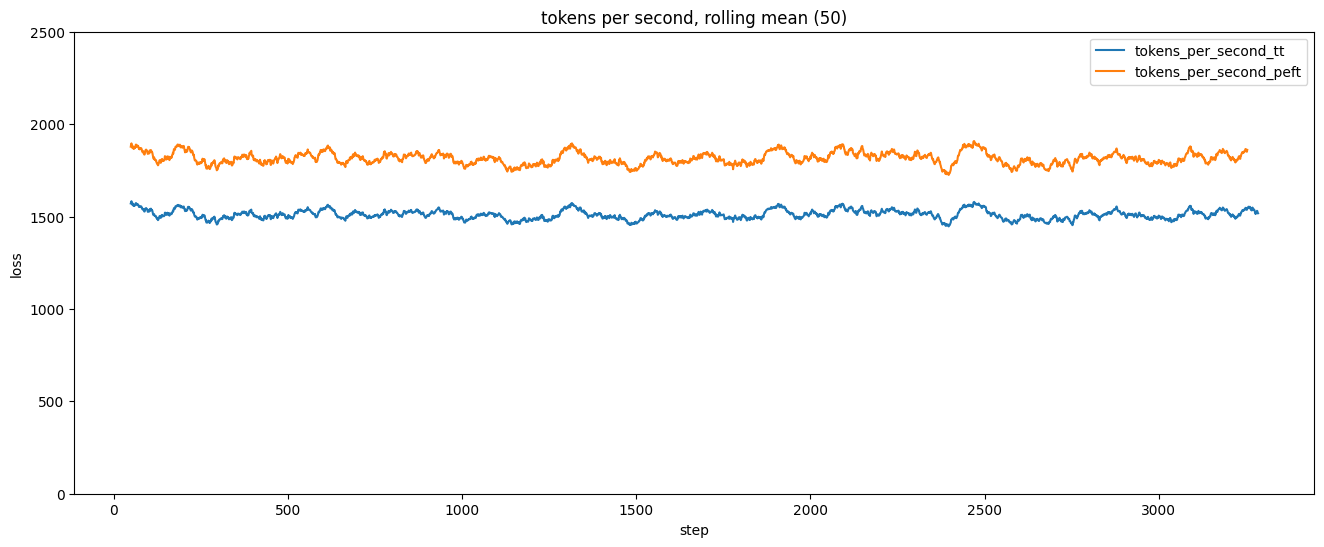

In [18]:
fig, ax = plt.subplots(figsize=(16, 6))
kw = {"ylabel": "loss", "xlabel": "step", "ylim": [0, 2500]}
df[["tokens_per_second_tt", "tokens_per_second_peft"]].rolling(50).mean().plot(ax=ax, title="tokens per second, rolling mean (50)", **kw)

### memory

not recorded for torchtune but nvidia-smi showed 23.01 GiB

<Axes: title={'center': 'memory, rolling mean (50)'}, xlabel='step', ylabel='loss'>

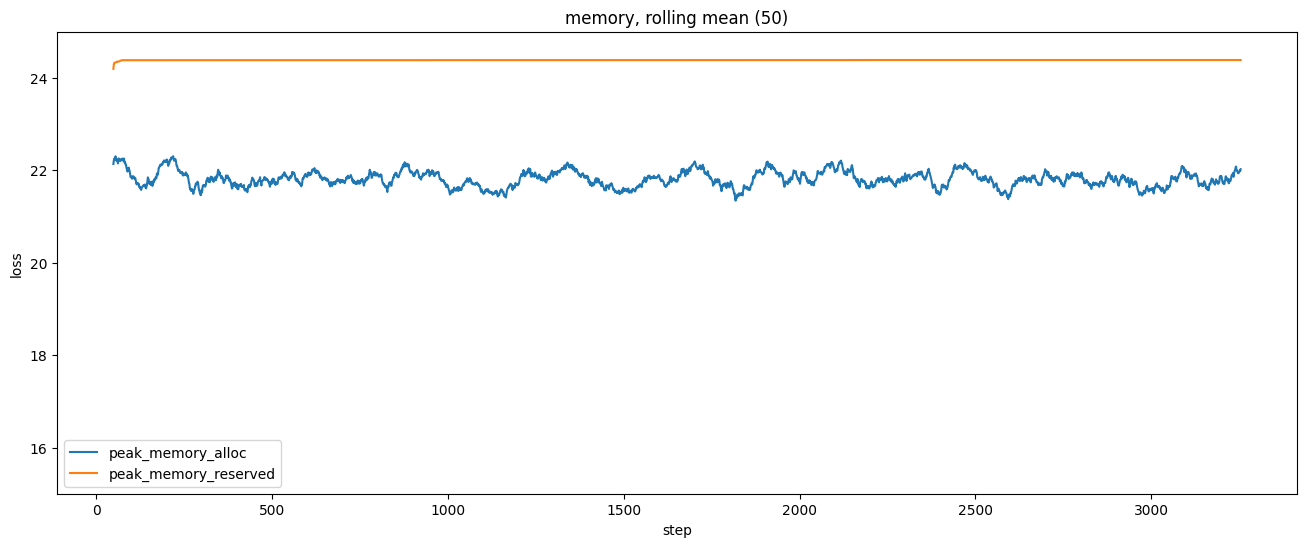

In [30]:
fig, ax = plt.subplots(figsize=(16, 6))
kw = {"ylabel": "loss", "xlabel": "step", "ylim": [15, 25]}
df[["peak_memory_alloc", "peak_memory_reserved"]].rolling(50).mean().plot(ax=ax, title="memory, rolling mean (50)", **kw)